In [2]:
## IMPORTS

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [3]:
## ARTWORKS DATAFRAME

artworks_df = pd.read_json('../temporary-files/artrio_artworks_info.json')
artworks_df.columns

Index(['Artist', 'Title', 'Size', 'Price', 'Sobre a obra', 'Ficha técnica',
       'Sobre o artista', 'ARTE HALL', 'MOVIMENTO ', 'Galeria Athena',
       'Arte FASAM Galeria', 'MARTHA PAGY ESCRITÓRIO DE ARTE',
       'EDITORA COBOGÓ', 'MUL.TI.PLO ESPAÇO ARTE', 'Artistas Latinas',
       'Lona Galeria', 'MERCEDES VIEGAS ARTE CONTEMPORÂNEA',
       'CASSIA BOMENY GALERIA', 'CARCARA PHOTO ART', 'PORTAS VILASECA GALERIA',
       'C.GALERIA', 'RV CULTURA E ARTE', 'Central Galeria', 'NARA ROESLER',
       'LUCIANA BRITO GALERIA', 'JANAINA TORRES GALERIA',
       'MATIAS BROTAS ARTE CONTEMPORÂNEA',
       'GABY INDIO DA COSTA ARTE CONTEMPORÂNEA', 'Aura Galeria',
       'CARBONO GALERIA', 'OMA Galeria',
       'MARCIA BARROZO DO AMARAL - Galeria de Arte',
       'FORTES D'ALOIA & GABRIEL', 'SILVIA CINTRA + BOX 4',
       'SIMÕES DE ASSIS GALERIA', 'FÓLIO', 'GALERIA ESTAÇÃO', 'GALERIA LUME',
       'BORDALLO', 'ANITA SCHWARTZ GALERIA ', 'GALERIA MAPA',
       'Metaverse Agency  ', 'Yaak Gallery

In [4]:
artworks_df['Sobre a obra'].describe()

count     944
unique    196
top          
freq      600
Name: Sobre a obra, dtype: object

In [5]:
## FIX PRICE AND SIZE COLUMNS

## Fix Size column

artworks_df['Size'] = artworks_df['Size'].str.replace('Ø', '0').replace(' ', '')
# Size column: height, width and depth (when present) as float (example: "14,5 \u00d7 20 \u00d7 cm")
artworks_df[['Height', 'Width', 'Depth']] = artworks_df['Size'].str.split(' × ', expand=True)

for column_name in ['Height', 'Width', 'Depth']:
    artworks_df[column_name] = artworks_df[column_name].str.replace(',', '.', regex=True).replace(' ', '', regex=True)    
    artworks_df[column_name] = artworks_df[column_name].str.findall(r'(\d+\.?\d*)')
    artworks_df[column_name] = artworks_df[column_name].apply(lambda x: ''.join(x))
    # convert to float or nan if empty
    artworks_df[column_name] = artworks_df[column_name].apply(lambda x: float(x) if x else None)

artworks_df.drop(columns=['Size'], inplace=True)

# area = height * width
artworks_df['Area'] = artworks_df['Height'].astype(float) * artworks_df['Width'].astype(float)

# Fix Price column
pattern = r'\d+'
artworks_df['Price'] = artworks_df['Price'].apply(lambda x: ''.join(re.findall(pattern, x)))
artworks_df['Price'] = artworks_df['Price'].astype(float) / 100

# Price / cm2
artworks_df['Price / cm2'] = artworks_df['Price'] / artworks_df['Area']

# Gallery column
galleries_list = artworks_df.columns[~artworks_df.columns.isin(['Artist', 'Title', 'Size', 'Price', 'Sobre a obra', 'Ficha técnica', 'Sobre o artista', 'Width', 'Height', 'Depth', 'Area'])].tolist()
# gallery is the first column that is not nan
artworks_df['Gallery'] = artworks_df[galleries_list].apply(lambda x: x.first_valid_index(), axis=1)

In [6]:
# get 5 artworks with highest value on 'column'
column = 'Price'
artworks_df.sort_values(by=column, ascending=False).head(5)
artworks_df.to_csv('../temporary-files/artrio_artworks_info.csv', index=False)


In [7]:
# Get the most common words in 'FICHA TÉCNICA' column
from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('portuguese')
stopwords.extend(['.',
                    ',',
                    'e',
                    'de',
                    'da',
                    'do',
                    'dos',
                    'das',
                    'o',
                    'a',
                    'os',
                    'as',
])

def get_most_common_words(column, top=10):
    words = artworks_df[column].str.lower().str.split().sum()
    words = [word for word in words if word not in stopwords]
    return Counter(words).most_common(top)

get_most_common_words('Ficha técnica', 20)


LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\Dell/nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.1264.0_x64__qbz5n2kfra8p0\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.1264.0_x64__qbz5n2kfra8p0\\share\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.1264.0_x64__qbz5n2kfra8p0\\lib\\nltk_data'
    - 'C:\\Users\\Dell\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [ ]:
# Linear regression: size (h * w) x median price

x_columns = ['Area']
y_column = 'Price'

X = artworks_df[artworks_df['Height'].notnull() & artworks_df['Width'].notnull()][x_columns]
y = artworks_df[artworks_df['Height'].notnull() & artworks_df['Width'].notnull()][y_column]

reg = LinearRegression().fit(X, y)

reg.score(X, y)

0.03051747918960812

In [ ]:
## GALLERIES DATAFRAME

galleries_minimum_count = 10
galleries_sort_by = 'Mean Price'

# list of all columns except ['Artist', 'Title', 'Size', 'Price', 'Sobre a obra', 'Ficha técnica', 'Sobre o artista', 'Width', 'Height', 'Depth']
galleries_list = artworks_df.columns[~artworks_df.columns.isin(['Artist', 'Gallery', 'Title', 'Size', 'Price', 'Sobre a obra', 'Ficha técnica', 'Sobre o artista', 'Width', 'Height', 'Depth', 'Area'])].tolist()
galleries_df = pd.DataFrame(index=galleries_list, columns=['Artworks Count', 'Mean Price', 'Median Price', 'Mean Price / cm²', 'Median Price / cm²', 'Total Offer'])
for gallery in galleries_list:
    galleries_df.loc[gallery] = artworks_df[gallery].count()
    # mean price of artworks that have non-Nan value in the corresponding column
    galleries_df.loc[gallery, 'Mean Price'] = artworks_df[artworks_df[gallery].notnull()]['Price'].mean().round(2)
    galleries_df.loc[gallery, 'Median Price'] = artworks_df[artworks_df[gallery].notnull()]['Price'].median().round(2)
    galleries_df.loc[gallery, 'Mean Price/ cm²'] = (artworks_df[artworks_df[gallery].notnull()]['Price'] / artworks_df[artworks_df[gallery].notnull()]['Area']).mean().round(2)
    galleries_df.loc[gallery, 'Median Price/ cm²'] = (artworks_df[artworks_df[gallery].notnull()]['Price'] / artworks_df[artworks_df[gallery].notnull()]['Area']).median().round(2)
    galleries_df.loc[gallery, 'Total Offer'] = artworks_df[artworks_df[gallery].notnull()]['Price'].sum().round(2)
    # Artists count is the number of non-Nan values in the corresponding column
    galleries_df.loc[gallery, 'Artists Count'] = artworks_df[artworks_df[gallery].notnull()]['Artist'].nunique()#.astype(int)


galleries_df.sort_values(by=galleries_sort_by, ascending=False, inplace=True)
galleries_df = galleries_df[galleries_df['Artworks Count'] >= galleries_minimum_count]


galleries_df

,Artworks Count,Mean Price,Median Price,Mean Price / cm²,Median Price / cm²,Total Offer,Mean Price/ cm²,Median Price/ cm²,Artists Count
GALERIA ESTAÇÃO,32,94718.75,86500.0,32,32,3031000.0,62.86,24.71,11.0
MILLAN,32,90843.75,47500.0,32,32,2907000.0,21.16,12.00,30.0
FÓLIO,19,75736.84,45000.0,19,19,1439000.0,216.21,68.65,9.0
Superfície,13,31500.0,30000.0,13,13,409500.0,6.92,8.33,6.0
LUCIANA BRITO GALERIA,29,30327.59,25000.0,29,29,879500.0,7.48,3.87,12.0
MATIAS BROTAS ARTE CONTEMPORÂNEA,16,27334.38,26000.0,16,16,437350.0,96.26,6.78,6.0
GALERIA MARIO COHEN,21,22952.38,18000.0,21,21,482000.0,5.07,3.81,7.0
MERCEDES VIEGAS ARTE CONTEMPORÂNEA,80,22619.92,15000.0,80,80,1809594.0,20.66,4.05,28.0
ANITA SCHWARTZ GALERIA,20,18600.0,15000.0,20,20,372000.0,6.84,5.25,14.0
CASSIA BOMENY GALERIA,19,18302.63,9000.0,19,19,347750.0,14.75,4.46,15.0


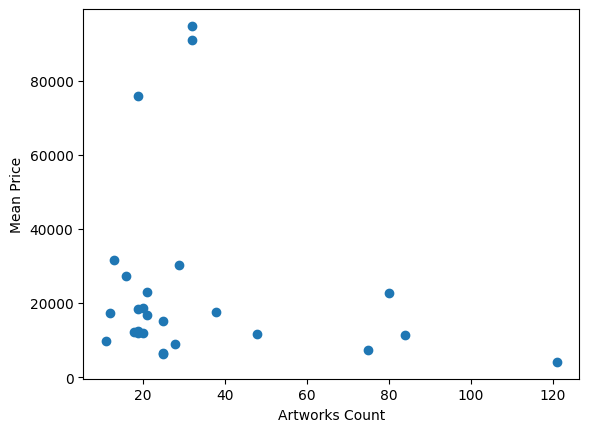

In [ ]:
## SCATTER PLOT

def scatter_plot(scatter_df, scatter_x_column, scatter_y_column):
    plt.scatter(scatter_df[scatter_x_column], scatter_df[scatter_y_column])
    plt.xlabel(scatter_x_column)
    plt.ylabel(scatter_y_column)
    plt.show()

scatter_df = galleries_df
scatter_x_column = 'Artworks Count'
scatter_y_column = 'Mean Price'
scatter_plot(scatter_df, scatter_x_column, scatter_y_column)

In [ ]:
artists_sort_by = 'Mean Price'
artists_minimum_count = 5

# new dataframe aggregating by artists (count, mean price, median price, mean price / cm², median price / cm², total offer)
artists_df = pd.DataFrame(index=artworks_df['Artist'].unique(), columns=['Count', 'Mean Price', 'Median Price', 'Mean Price / cm²', 'Median Price / cm²', 'Total Offer'])
# define columns
# count
artists_df['Count'] = artworks_df.groupby('Artist')['Artist'].count()
artists_df['Mean Price'] = artworks_df.groupby('Artist')['Price'].mean().round(2)
artists_df['Median Price'] = artworks_df.groupby('Artist')['Price'].median().round(2)
artists_df['Mean Price / cm²'] = (artworks_df.groupby('Artist')['Price'].sum() / artworks_df.groupby('Artist')['Area'].sum()).round(2)
artists_df['Median Price / cm²'] = (artworks_df.groupby('Artist')['Price'].median() / artworks_df.groupby('Artist')['Area'].median()).round(2)
artists_df['Total Offer'] = artworks_df.groupby('Artist')['Price'].sum().round(2)

artists_df['Galleries'] = artworks_df.groupby('Artist')['Gallery'].unique().apply(lambda x: ', '.join(x))

artists_df.sort_values(by=artists_sort_by, ascending=False, inplace=True)
artists_df = artists_df[artists_df['Count'] >= artists_minimum_count]

artists_df

,Count,Mean Price,Median Price,Mean Price / cm²,Median Price / cm²,Total Offer,Galleries
José Antonio da Silva,9,95222.22,95000.0,26.36,27.14,857000.0,GALERIA ESTAÇÃO
Almandrade,8,67875.00,52000.0,25.16,34.90,543000.0,"CARBONO GALERIA, ACERVO GALERIA DE ARTE, MERCE..."
Anna Maria Maiolino,6,59766.67,85000.0,60.64,89.59,358600.0,"CASSIA BOMENY GALERIA, MERCEDES VIEGAS ARTE CO..."
Arthur Luiz Piza,9,53555.56,30000.0,53.05,34.29,482000.0,FÓLIO
Armarinhos Teixeira,6,47500.00,30000.0,19.22,8.82,285000.0,MATIAS BROTAS ARTE CONTEMPORÂNEA
José Pedro Croft,5,30600.00,13000.0,11.42,7.43,153000.0,MUL.TI.PLO ESPAÇO ARTE
Osvaldo Carvalho,6,29366.67,27700.0,1.93,2.12,176200.0,JANAINA TORRES GALERIA
Germana Monte-Mór,6,28833.33,25000.0,4.51,6.84,173000.0,GALERIA ESTAÇÃO
Adalberto Mecarelli,5,23999.60,18000.0,3.13,3.01,119998.0,MERCEDES VIEGAS ARTE CONTEMPORÂNEA
Sebastião Salgado,8,21625.00,13000.0,4.57,7.03,173000.0,GALERIA MARIO COHEN


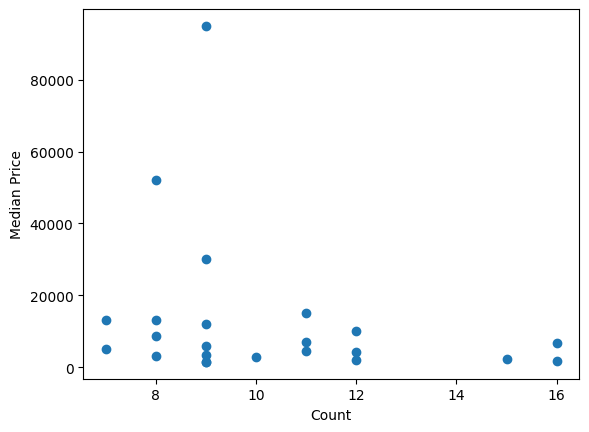

In [ ]:
scatter_plot(artists_df, 'Count', 'Median Price')